In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import regex as re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve,ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD

# EDA

In [3]:
# Importing Training data as df
df = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
# checking data samples
df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [4]:
feature_list = df.columns.drop("Rating").values
label = ["Rating"]

print ("Feature list:", feature_list)
print ("Label:", label)

Feature list: ['ID' 'RecipeNumber' 'RecipeCode' 'RecipeName' 'CommentID' 'UserID'
 'UserName' 'UserReputation' 'CreationTimestamp' 'ReplyCount'
 'ThumbsUpCount' 'ThumbsDownCount' 'BestScore' 'Recipe_Review']
Label: ['Rating']


In [5]:
# checking the shape of the training data
df.shape

(13636, 15)

there are 13636 rows and 15 columns

In [6]:
# checking the information( like columns name with count of non null data points and the data types) about different columns present in the training data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


all the columns dont have any null data point except the Recipe_Review column which have two null data point present. few columns are non numeric like  RecipeName, CommentID, UserID, UserName and Recipie_Review

In [7]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

only 2 null data points are present that also in the Recipie_Review column that is categorical, so dropped

In [8]:
# checking Descriptive Statistics
df.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13634.00000,13634.000000,13634.000000,13634.000000,1.363400e+04,13634.000000,13634.000000,13634.000000,13634.000000,13634.00000
mean,121.05589,38.629382,21787.406117,2.160481,1.623714e+09,0.014523,1.098430,0.543788,4.288617,153.13569
std,116.97871,29.671643,23884.389851,10.087154,5.444406e+06,0.137333,4.166771,3.265893,1.544928,140.99578
min,0.00000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.00000
25%,45.00000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.00000
50%,91.00000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.00000
75%,148.00000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.00000
max,724.00000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.00000


most of the data points are same even for 25%, 50% & 75% in almost all the columns for example in column ReplyCount, ThumbsUpCount, Rating & BestScore

In [9]:
df["Rating"].value_counts()

Rating
5    10369
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

there are lots of sample with high rating than others 

Text(0, 0.5, 'Count')

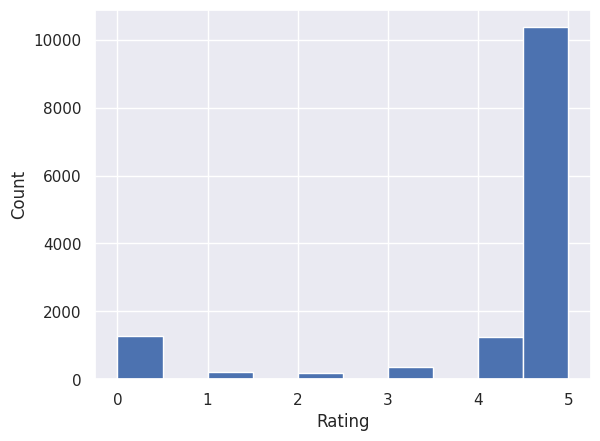

In [10]:
sns.set()
df.Rating.hist()
plt.xlabel("Rating")
plt.ylabel('Count')

bar of rating 5 is taller than others

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'RecipeNumber'}>,
        <Axes: title={'center': 'RecipeCode'}>],
       [<Axes: title={'center': 'UserReputation'}>,
        <Axes: title={'center': 'CreationTimestamp'}>,
        <Axes: title={'center': 'ReplyCount'}>],
       [<Axes: title={'center': 'ThumbsUpCount'}>,
        <Axes: title={'center': 'ThumbsDownCount'}>,
        <Axes: title={'center': 'BestScore'}>]], dtype=object)

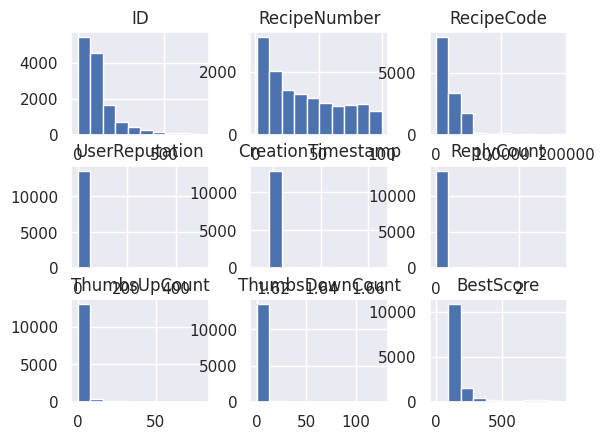

In [11]:
# checking how data from each numeric column is distributed
df.drop("Rating", axis = 1).hist()

* Features are at different scales.
* Features have different distributions -
    * All are right skewed,
    * All are tail heavy.

### Splitting the tranning and validation set

In [12]:
# seperating Features and target column
X = df.drop("Rating", axis = 1)
y = df["Rating"]

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, validation_index in split.split(df, df["Rating"]):
  strat_train_set = df.loc[train_index]
  strat_validation_set = df.loc[validation_index]

### Visualisation

In [14]:
#Creating Exploration Set for Visualisation
Exploration_set = strat_train_set.copy()

In [15]:
# selecting numerical columns
numerical_columns = Exploration_set.select_dtypes(exclude=['object'])

# checking corelation between numerical columns
linear_corr_matrix = numerical_columns.corr()

<Axes: >

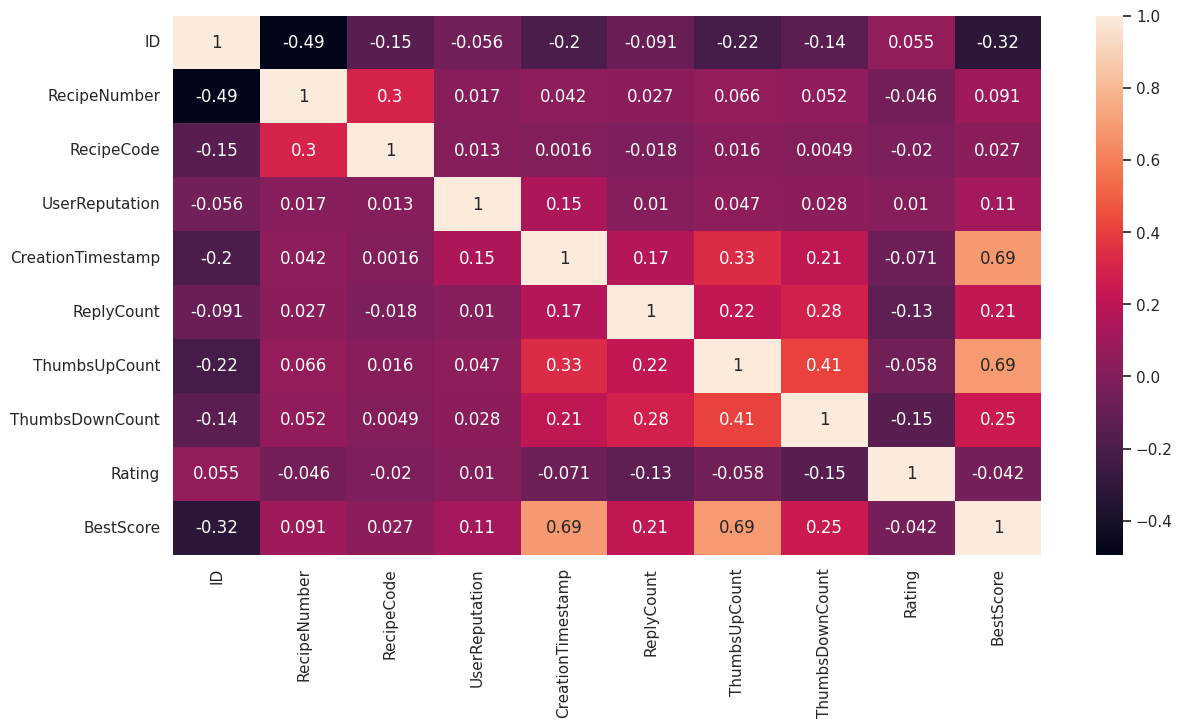

In [16]:
# visualising correlation
plt.figure(figsize = (14,7))
sns.heatmap(linear_corr_matrix, annot = True)

there is no significant linear correlation found between features and target column but there is Strong correlation between ThumbsUpCount and BestScore

In [17]:
# checking non linear relationship between numerical columns
non_linear_corr = numerical_columns.corr(method = "spearman" )

<Axes: >

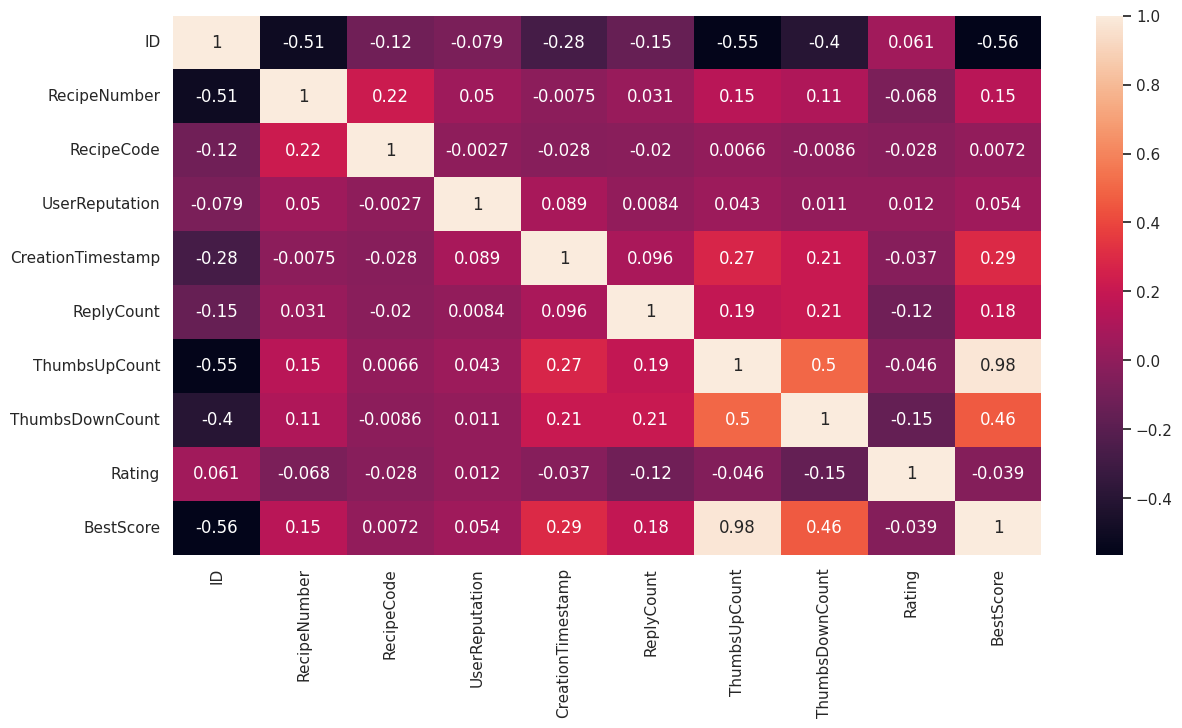

In [18]:
# visualising correlation
plt.figure(figsize = (14,7))
sns.heatmap(non_linear_corr, annot = True)


even there is no significant non linear correlation found between features and target column but there is strong correlation between ThumbsUpCount and BestScore

# Preparing data for ML algorithm

In [19]:
#Separating features and labels from the training set.
X_train = strat_train_set.drop("Rating", axis=1)
y_train = strat_train_set['Rating'].copy()

In [20]:
# droping features which are irrelevant for training model cosidering nature of the problem
X_train.drop(columns = ["ID","RecipeNumber","RecipeCode","RecipeName","CommentID","UserID", "UserName","CreationTimestamp"], inplace = True)

In [21]:
X_train

,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
4806,1,0,0,0,100,Made this for supper tonight everyone loved i...
9152,1,0,0,0,100,I made this with low calorie /fat free substit...
4277,1,0,1,0,193,This recipe was awesome! I followed it exactl...
11502,1,0,0,0,100,I would recommend cooking it an additional 20-...
437,1,0,0,1,100,My husband and I didn&#39;t like this recipe. ...
...,...,...,...,...,...,...
10715,1,0,0,0,100,"this is likely one of the easiest, tastiest so..."
9451,1,0,0,0,100,How do you print out this recipe. Don’t see an...
12460,1,0,0,0,100,My husband and I really enjoyed this recipe! W...
2195,1,0,0,0,100,Very quick and simple to make. Delicious!


## **Pre-processing data**

In [22]:
X_train.isna().sum()

UserReputation     0
ReplyCount         0
ThumbsUpCount      0
ThumbsDownCount    0
BestScore          0
Recipe_Review      0
dtype: int64

no null data points found in training features

In [23]:
def preprocess_text(text):
    # function to Remove punctuation, Tokenize, lowercasing and removing stopwords
    text = re.sub(r'[^\w\s]', ' ', text)
    # Tokenize and lowercase
    tokens = text.lower().split()
    #common English stop words
    stop_words = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])
    return [token for token in tokens if token not in stop_words]

In [24]:
# applying preprocessing function to Recipe_Review feature 
X_train['Preprocessed_Review'] = X_train['Recipe_Review'].apply(preprocess_text).apply(' '.join)

In [25]:
# dropping Recipe_Review feature after preprocessing it and storing as Preprocessed_Review
X_train.drop("Recipe_Review", axis = 1, inplace = True)

In [26]:
# selecting numerical columns name
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

In [27]:
#Separating features and labels from the training set.
X_validation = strat_validation_set.drop("Rating", axis=1)
y_validation = strat_validation_set['Rating'].copy()

In [28]:
#removing irrelevant columns as removed in training data
X_validation.drop(columns = ["ID","RecipeNumber","RecipeCode","RecipeName","CommentID","UserID", "UserName","CreationTimestamp"], inplace = True)
X_validation['Preprocessed_Review'] = X_validation['Recipe_Review'].astype(str).apply(preprocess_text).apply(' '.join)
X_validation.drop("Recipe_Review", axis = 1, inplace = True)

In [29]:
# Defining preprocessing steps for numerical and text features directly within ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), [0, 1, 2, 3, 4]),  # Scaling numerical features
    ('text', TfidfVectorizer(), 5)  # Transforming text data into TF-IDF vectors
])

# Model Tranning and Evaluation

## Base-line model (Logistic Regression)

In [30]:
# Defining the final pipeline with preprocessing and classification steps
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing numerical and text features
    ('clf', LogisticRegression(max_iter = 1000,C=2))  # Step 2: Fitting logistic regression model
])

# Fitting the pipeline on the training data
logistic_pipeline.fit(X_train, y_train)

y_pred_logistic = logistic_pipeline.predict(X_validation)

# evaluating prediction made on validation set
from sklearn.metrics import classification_report
eval = classification_report(y_validation,y_pred_logistic)
print(eval)

              precision    recall  f1-score   support

           0       0.45      0.16      0.23       318
           1       0.36      0.08      0.12        53
           2       0.25      0.02      0.04        43
           3       0.44      0.09      0.15        92
           4       0.39      0.11      0.17       310
           5       0.80      0.98      0.88      2593

    accuracy                           0.77      3409
   macro avg       0.45      0.24      0.27      3409
weighted avg       0.70      0.77      0.71      3409



### Processing test data as training was preprocessed

In [31]:
# importing test data for submission
df_test = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")
X_test = df_test
X_test

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,86,45,41384,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...
1,102,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad...."
2,156,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.
3,18,89,1324,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,1,1622648872,0,4,3,212,I made this and followed the instructions as d...
4,27,70,32264,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4541,152,32,17310,Seafood Lasagna,sp_aUSaElGf_17310_c_310012,u_1oKYP0QIv00q3K9Z5U0TosT5gYx,jsantullo,1,1622717899,0,0,0,100,This is an absolutely wonderful seafood recipe...
4542,121,74,26937,Pineapple Pudding Cake,sp_aUSaElGf_26937_c_331905,u_1oKVlhuSfIH4M8gwWLvmkvs3215,homeoftaste,1,1622717990,0,0,0,100,This us a definite &#34;OMG&#34;. Tastes sinf...
4543,133,73,41095,Contest-Winning New England Clam Chowder,sp_aUSaElGf_41095_c_112060,u_1oKVb3oC9QR5uDI8OqeaPncMtBe,cmfisher,1,1622716903,0,0,0,100,absolutely great....even husband and grandson ...
4544,91,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_391682,u_1oKcs7T7xAY63ZrRKCwH8ccshww,danalu8,1,1622718289,0,0,1,100,I followed directions. It tastes very bland. V...


In [32]:
#removing irrelevant columns as removed in training data
X_test.drop(columns = ["ID","RecipeNumber","RecipeCode","RecipeName","CommentID","UserID", "UserName","CreationTimestamp"], inplace = True)
X_test['Preprocessed_Review'] = X_test['Recipe_Review'].astype(str).apply(preprocess_text).apply(' '.join)
X_test.drop("Recipe_Review", axis = 1, inplace = True)

## Performing Cross-validation for Logistic Regression

In [33]:
kfold_cv = KFold(n_splits=5)
score = cross_val_score(logistic_pipeline, X_train, y_train, cv=kfold_cv)

In [34]:
#checking cross validation score of each model trained on different folds and mean of all the scores
print(score)
print(score.mean())

[0.7794621  0.76674817 0.76772616 0.77310513 0.77457213]
0.772322738386308


mean score is closed to accuracy we got from Logistic pipeline so we can conclude that model is not Over fitted

### Hyper parameter tunning for Logistic model

In [35]:
param_grid = {'clf__C': [1.3,1.4, 1.5, 1.6, 1.7, 1.8],
              'clf__max_iter': [1000, 2000, 3000]}

# Performing RandomizedSearchCV for hyperparameter tuning
logistic_search = RandomizedSearchCV(logistic_pipeline, param_grid, n_jobs=-1, cv=5)
logistic_search.fit(X_train, y_train)

print("Best parameters:", logistic_search.best_params_)
print("Best cross-validation score:", round(logistic_search.best_score_, 2))

Best parameters: {'clf__max_iter': 1000, 'clf__C': 1.7}
Best cross-validation score: 0.77


After tunning hyper parameter tunning accuracy is not much changed, even round off value is same

### Fitting KNeighborsClassifier

In [36]:
# Defining the final pipeline with preprocessing and classification steps
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing numerical and text features
    ('knn_model', KNeighborsClassifier(n_neighbors=5))  # Step 2: Fitting logistic regression model
])

# Fitting the pipeline on the training data
knn_pipeline.fit(X_train, y_train)

y_pred_knn = knn_pipeline.predict(X_validation)

In [37]:
# Evaluating the model's performance
accuracy = accuracy_score(y_validation, y_pred_knn)
print("Accuracy:", accuracy)

Accuracy: 0.7453798767967146


* Accuracy is even less than the base line model.
* it is correctly predicting approximately 75% of all the predictions made

### Performing Hyper parameters Tunning for KNeighborsClassifier

In [38]:
#Tunning hyper parameters to enhance the performance
param_grid = {
    'knn_model__n_neighbors': [3, 5, 7],
    'knn_model__weights': ['uniform', 'distance'],
    'knn_model__p': [1, 2]
}

# Performing RandomizedSearchCV for hyperparameter tuning
search = RandomizedSearchCV(knn_pipeline, param_grid, n_jobs=-1, cv=5)
search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best cross-validation score:", round(search.best_score_, 2))

Best parameters: {'knn_model__weights': 'distance', 'knn_model__p': 2, 'knn_model__n_neighbors': 7}
Best cross-validation score: 0.76


* Accuracy is more than before but still less than base model

### Fitting SVC 

In [39]:
# Defining the final pipeline with preprocessing and classification steps
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing numerical and text features
    ('svm_model', SVC())  # Step 2: Fitting logistic regression model
])

# Fitting the pipeline on the training data
svm_pipeline.fit(X_train, y_train)

y_pred_svc = svm_pipeline.predict(X_validation)

# Evaluating the model's performance
accuracy = accuracy_score(y_validation, y_pred_svc)
print("Accuracy:", accuracy)

Accuracy: 0.7618069815195072


explains 76% of all the predictions made

### Fitting DecisionTreeClassifier 

In [40]:
# Defining the final pipeline with preprocessing and classification steps
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing numerical and text features
    ('tree_model', DecisionTreeClassifier())  # Step 2: Fitting logistic regression model
])

# Fitting the pipeline on the training data
tree_pipeline.fit(X_train, y_train)

y_pred_tree = tree_pipeline.predict(X_validation)

# Evaluating the model's performance
accuracy = accuracy_score(y_validation, y_pred_tree)
print("Accuracy:", accuracy)

Accuracy: 0.6808448225286008


* Accuracy is least as compared to all the model    fitted till now
* explains 68% of all the predictions made

### Fitting RandomForestClassifier

In [41]:
# Defining the final pipeline with preprocessing and classification steps
forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing numerical and text features
    ('forest_model', RandomForestClassifier(random_state=21))  # Step 2: Fitting a RandomForestClassifier model
])

# Fitting the pipeline on the training data
forest_pipeline.fit(X_train, y_train)

y_pred_forest = forest_pipeline.predict(X_validation)

# Evaluating the model's performance
accuracy = accuracy_score(y_validation, y_pred_forest)
print("Accuracy:", accuracy)

Accuracy: 0.7735406277500734


* Accuracy is better from the earlier models
* explains more than 77.35% of all the predictions

### Fitting XGBClassifier

In [42]:
# Defining the final pipeline with preprocessing and classification steps
XGB_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing numerical and text features
    ('XGB_model', XGBClassifier())  # Step 2: Fitting a XGBClassifier model
])

# Fitting the pipeline on the training data
XGB_pipeline.fit(X_train, y_train)

y_pred_xgb = XGB_pipeline.predict(X_validation)

# Evaluating the model's performance
accuracy = accuracy_score(y_validation, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.7723672631270168


* Accuracy is almost simmilar to RandomForestClassifier but slightly less

## Comparing Performance of Best three model

In [43]:
#function to plot confusion matrix
def plot_confusion_matrix(data, labels=None):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(8, 4))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'},fmt="d")
    if labels:
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 1)
    ax.set(ylabel="True Label (User Collected Value)", xlabel="Predicted Label")
    plt.show()

### comapring different models performance

In [44]:
def compare_models(models, X_test, y_test):
    Models = []
    Accuracy = []
    Precision = []
    Recall = []
    F1_score = []

    for model_name, model_pipeline in models.items():
        # Making predictions
        y_pred = model_pipeline.predict(X_test)

        # Calculating evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')


        # Appending metrics to lists
        Models.append(model_name)
        Accuracy.append(accuracy)
        Precision.append(precision)
        Recall.append(recall)
        F1_score.append(f1)

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred, labels=model_pipeline.classes_)
        plot_confusion_matrix(conf_matrix)
        
        # Displaying confusion matrix
        from sklearn.metrics import classification_report
        print(f'\n\nClassification Matrix for {model_name}')
        print(classification_report(y_test, y_pred))


    # Creating a DataFrame to summarize model performance
    df = pd.DataFrame({
        'Models': Models,
        'Accuracy': Accuracy,
        'Precision': Precision,
        'Recall': Recall,
        'F1_score': F1_score,
    }).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

    return df


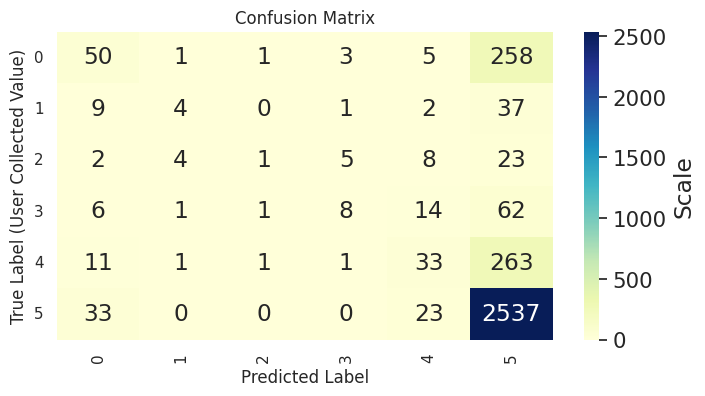



Classification Matrix for Logistic_Model
              precision    recall  f1-score   support

           0       0.45      0.16      0.23       318
           1       0.36      0.08      0.12        53
           2       0.25      0.02      0.04        43
           3       0.44      0.09      0.15        92
           4       0.39      0.11      0.17       310
           5       0.80      0.98      0.88      2593

    accuracy                           0.77      3409
   macro avg       0.45      0.24      0.27      3409
weighted avg       0.70      0.77      0.71      3409



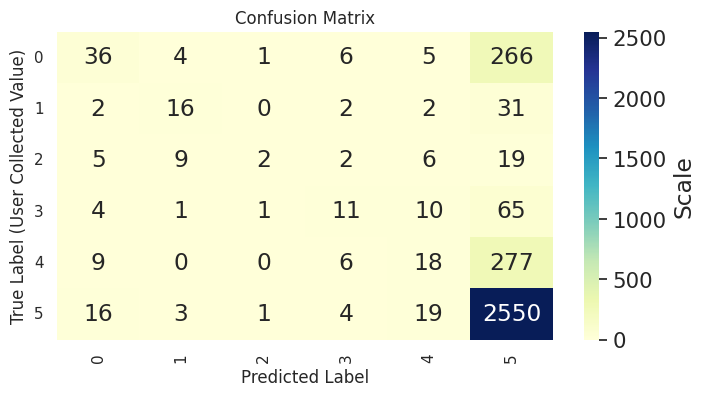



Classification Matrix for XGB_Model
              precision    recall  f1-score   support

           0       0.50      0.11      0.18       318
           1       0.48      0.30      0.37        53
           2       0.40      0.05      0.08        43
           3       0.35      0.12      0.18        92
           4       0.30      0.06      0.10       310
           5       0.79      0.98      0.88      2593

    accuracy                           0.77      3409
   macro avg       0.47      0.27      0.30      3409
weighted avg       0.70      0.77      0.71      3409



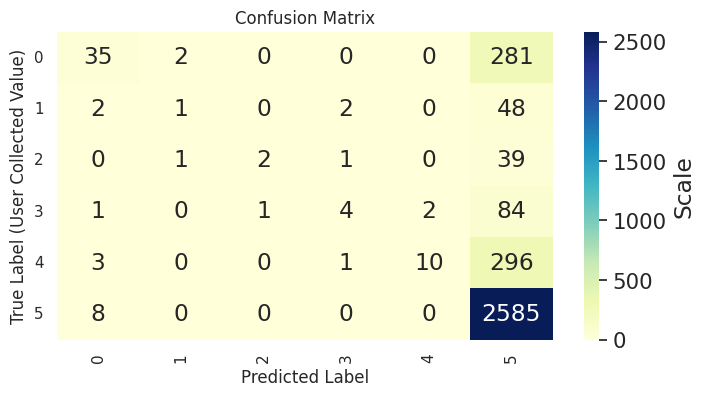



Classification Matrix for Rndom_forest_Model 
              precision    recall  f1-score   support

           0       0.71      0.11      0.19       318
           1       0.25      0.02      0.04        53
           2       0.67      0.05      0.09        43
           3       0.50      0.04      0.08        92
           4       0.83      0.03      0.06       310
           5       0.78      1.00      0.87      2593

    accuracy                           0.77      3409
   macro avg       0.62      0.21      0.22      3409
weighted avg       0.76      0.77      0.69      3409



,Models,Accuracy,Precision,Recall,F1_score
0,Rndom_forest_Model,0.773541,0.758130,0.773541,0.690839
1,Logistic_Model,0.772367,0.704957,0.772367,0.711879
2,XGB_Model,0.772367,0.700700,0.772367,0.706450


In [45]:
best_models = {'Logistic_Model': logistic_pipeline, 'XGB_Model': XGB_pipeline, 'Rndom_forest_Model ': forest_pipeline}
compare_models(best_models, X_validation, y_validation)

* Best model out of top three models is Random Forest model according to accuracy score But
    * If we consider precision and Recall we know that our model is biased towards the 5th Rating that is why the score is good on 5 rating as compared to other rating 
* there is a tie between Logistic and XGB model according accuracy score but average precision and recall are more balanced in XGB model as compared to all three

## Using dimensionality reduction Tecnique for XGBoost model

In [46]:
# Defining the TruncatedSVD transformer
svd = TruncatedSVD(n_components=700, random_state=42)  # Specifing the number of components which explains 95% of variance

# Defining the final pipeline with preprocessing, TruncatedSVD, and classification steps
XGB_pipeline_with_SVD = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Step 1: Preprocessing numerical and text features
    ('svd', svd),  # Step 2: TruncatedSVD transformation
    ('XGB_model', XGBClassifier(random_state=21))  # Step 3: Fitting a XGBClassifier model
])

# Fitting the pipeline on the training data
XGB_pipeline_with_SVD.fit(X_train, y_train)

# Making predictions on the validation set
y_pred_xgb = XGB_pipeline_with_SVD.predict(X_validation)

# Evaluating the model's performance
accuracy = accuracy_score(y_validation, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.7753006746846582


After selecting the features which explain 95% of variance Accuracy is increased

In [47]:
eval = classification_report(y_validation,y_pred_xgb)
print(eval)

              precision    recall  f1-score   support

           0       0.59      0.12      0.20       318
           1       0.50      0.09      0.16        53
           2       0.67      0.05      0.09        43
           3       0.75      0.03      0.06        92
           4       0.54      0.07      0.13       310
           5       0.78      0.99      0.88      2593

    accuracy                           0.78      3409
   macro avg       0.64      0.23      0.25      3409
weighted avg       0.74      0.78      0.70      3409



### making predictions on test data through XGB model pipeline with SVD

In [48]:
# # predictions on test data through XGBoost pipeline
# y_pred_submission = XGB_pipeline_with_SVD.predict(X_test)

In [49]:
# # creating submission file
# submission = pd.DataFrame({"ID": range(1,4547), 
#                            "total_amount": y_pred_submission}) 

# submission.to_csv('submission.csv',index=False)

Accuracy was pretty good on validation set still accuracy was less on test set

### Making predictions on test data through XGB pipeline

In [50]:
# predictions on test data through XGBoost pipeline
y_pred_submission = XGB_pipeline.predict(X_test)

In [51]:
# creating submission file
submission = pd.DataFrame({"ID": range(1,4547), 
                           "total_amount": y_pred_submission}) 

submission.to_csv('submission.csv',index=False)